In [21]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import RLSystem
import os
import threading


2024-04-09 18:25:27.226891: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 18:25:27.248373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 18:25:27.248397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 18:25:27.249188: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 18:25:27.253076: I tensorflow/core/platform/cpu_feature_guar

'theta_O1'

In [23]:
import mne
import pandas as pd

In [4]:
from importlib import reload
reload(RLSystem)
import numpy as np
import time

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [78]:
npdp='/home/biorp/Documents/PlatformIO/Projects/SFSystem_withAV/session_lib/default_session/default_session_edf/default_session_edf.npd'
edfp='/home/biorp/Documents/PlatformIO/Projects/SFSystem_withAV/session_lib/default_session/default_session_edf/default_session_edf.edf'
annp='/home/biorp/Documents/PlatformIO/Projects/SFSystem_withAV/session_lib/default_session/default_session_edf/default_session_edf.log'
npd=pd.read_csv(npdp, sep=';')
ann=pd.read_csv(annp, sep='\t', header=None)
# Replace 'your_file.edf' with the path to your EDF file
edf = mne.io.read_raw_edf(edfp, preload=True)

Extracting EDF parameters from /home/biorp/Documents/PlatformIO/Projects/SFSystem_withAV/session_lib/default_session/default_session_edf/default_session_edf.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 16124  =      0.000 ...   128.992 secs...


/tmp/ipykernel_68922/1565238313.py:7: RuntimeWarning:

Limited 1 annotation(s) that were expanding outside the data range.



In [114]:
edfp='/home/biorp/Documents/PlatformIO/Projects/SFSystem_withAV/session_lib/default_session/default_session_edf/default_session_edf.edf'
edf = mne.io.read_raw_edf(edfp, preload=True)

# Extract the data from the EDF file
data = edf.get_data()
annotations=edf.annotations.to_data_frame()

# Get the channel names
ch_names = edf.ch_names

# Create a pandas DataFrame
df = pd.DataFrame(data.T, columns=ch_names)
df['t']=edf.times
annotations['t']=edf.annotations.onset
anndescriptors=annotations['description'].unique().tolist()
sann=False
eann=False
micann=False
actann=False
rewann=False
acts={}
micfs={}
steprewards={}
episode_total_rewards={}
alltimestamps=df['t'].tolist()

anndata={}

cstep=0
cepisode=0
cts=0
crev=0
etrev=0
cact=None
cmiclogf=None
for i in annotations.index.tolist():
    anndata=annotations.iloc[i]
    descr=anndata['description']
    #onset=anndata['t']
    if 'episode_' in descr:
        episode=descr.split('episode_').split('_')[0]
        cepisode=episode
    if '_step_' in descr:
        step=descr.split('_step_')[1]
        cstep=step
        onset=anndata['t'] #onsets aalign with step onset
    if 'sr_' in descr:
        reward=float(descr.split('sr_')[1].split('_')[0])
        crev=reward
        steprewards[f't_{onset}_ep_{cepisode}_step{cstep}']=crev
    if '_tcer_' in descr:
        episode_total_reward=descr.split('_tcer_')[1]
        etrev=episode_total_reward
        episode_total_rewards[f't_{onset}_ep_{cepisode}']=etrev
    if 'MICLOGF' in descr:
        miclogf=descr.split('MICLOGF_')[1]
        cmiclogf=miclogf
        micfs[onset]=cmiclogf
    if 'action' in descr:
        action=descr.split('action_')[1]
        cact=action
        acts[onset]=action
    anndata[onset]={'episode':cepisode,
                    'step':cstep,
                    'miclogf':cmiclogf,
                    'action':cact,
                    'reward':crev}


anndata_edfonsets={}
anndata_keys=np.array(list(anndata.keys()))
for i in alltimestamps:
    tarkeys=anndata_keys[anndata_keys<i]
    tarind=np.argmin(np.abs(tarkeys - i))
    closest=tarkeys[tarind]
    anndata_edfonsets[i]=anndata[closest]

for i in anndescriptors:
    if 'episode_' in i:
        eann==True
    if 'step_' in i:
        sann==True
    if 'MICLOGF_' in i:
        micann==True
    if 'sr_' in i:
        rewann=True



if rewann==False:
    df['rev']=0
else:
    rewards=[]
    for i in anndata_edfonsets:
        rewards.append(anndata_edfonsets[i]['reward'])
    df['rev']=rewards
if sann==False:
    df['step']=0
else:
    steps=[]
    for i in anndata_edfonsets:
        steps.append(anndata_edfonsets[i]['step'])
    df['step']=steps
if sann==False:
    df['episode']=0
else:
    episodes=[]
    for i in anndata_edfonsets:
        episodes.append(anndata_edfonsets[i]['episode'])
    df['episode']=episodes

acts={}
miclogs={}


if actann==False:
    for i in alltimestamps:
        acts[i]='NotLogged'
else:
    for i in alltimestamps:
        acts[i]=anndata_edfonsets[i]['action']
if micann==False:
    for i in alltimestamps:
        miclogs[i]='NotLogged'
else:
    for i in alltimestamps:
        miclogs[i]=anndata_edfonsets[i]['miclogf']


In [115]:
df

,O1,P3,C3,F3,F4,C4,P4,O2,t
0,-0.002540,0.002741,-0.000425,-0.001173,0.002837,-0.000890,0.000118,0.005850,0.000
1,-0.003311,0.007407,-0.000455,-0.001830,0.010737,-0.006898,0.000040,0.011677,0.008
2,-0.003730,0.001044,-0.000494,-0.002889,0.000039,-0.003570,-0.000152,0.001451,0.016
3,-0.003172,-0.007329,-0.000527,-0.002634,-0.013881,0.003930,-0.000365,-0.011306,0.024
4,-0.002310,-0.007043,-0.000536,-0.002403,-0.012653,0.005640,-0.000331,-0.008974,0.032
...,...,...,...,...,...,...,...,...,...
16120,0.000925,0.001625,0.000925,0.000927,0.003920,0.002622,0.000923,0.004455,128.960
16121,0.000993,0.007165,0.000994,0.000997,0.004496,0.016819,0.000993,0.019660,128.968
16122,0.000860,0.006198,0.000860,0.000860,0.004130,0.009046,0.000859,0.010278,128.976
16123,0.000398,-0.000577,0.000397,0.000394,0.001896,-0.009446,0.000397,-0.010577,128.984


In [116]:
annotations

,onset,duration,description,t
0,2024-04-04 04:37:12.060,0.008,started_training_run,2024-04-04 04:37:12.060
1,2024-04-04 04:37:12.092,0.008,t_episode_0,2024-04-04 04:37:12.092
2,2024-04-04 04:37:34.278,10.000,episode_0_step_0,2024-04-04 04:37:34.278
3,2024-04-04 04:37:50.318,0.008,sr_0.0_tcer_0.0,2024-04-04 04:37:50.318
4,2024-04-04 04:37:50.355,0.008,comr_0.0,2024-04-04 04:37:50.355
5,2024-04-04 04:37:50.355,0.008,temr_0.0,2024-04-04 04:37:50.355
6,2024-04-04 04:37:50.409,10.000,episode_0_step_1,2024-04-04 04:37:50.409
7,2024-04-04 04:38:06.537,0.008,sr_0.0_tcer_0.0,2024-04-04 04:38:06.537
8,2024-04-04 04:38:06.538,0.008,comr_0.0,2024-04-04 04:38:06.538
9,2024-04-04 04:38:06.538,0.008,temr_0.0,2024-04-04 04:38:06.538


In [83]:
# Convert NPD timestamps to seconds
npd_timestamps_seconds = np.array(npd_timestamps) / 1000 # Assuming npd_timestamps is a list or array of your NPD timestamps

# Convert EDF timestamps to absolute time in seconds since the Unix epoch
edf_timestamps_absolute = recording_start_time_unix + edf.times

# Find the correspondence between the two sets of timestamps
# This is a simple example that finds the closest match for each NPD timestamp
# More sophisticated methods might be needed for accurate alignment
correspondences = []
for npd_ts in npd_timestamps_seconds:
    closest_match_index = np.argmin(np.abs(edf_timestamps_absolute - npd_ts))
    closest_match_edf_ts = edf_timestamps_absolute[closest_match_index]
    correspondences.append((npd_ts, closest_match_edf_ts))

# Print the correspondences
for npd_ts, edf_ts in correspondences:
    print(f"NPD Timestamp: {npd_ts}, Closest EDF Timestamp: {edf_ts}")

NPD Timestamp: 1712194625.95, Closest EDF Timestamp: 1712205425.0
NPD Timestamp: 1712194626.153, Closest EDF Timestamp: 1712205425.0
NPD Timestamp: 1712194626.369, Closest EDF Timestamp: 1712205425.0
NPD Timestamp: 1712194626.557, Closest EDF Timestamp: 1712205425.0
NPD Timestamp: 1712194626.749, Closest EDF Timestamp: 1712205425.0
NPD Timestamp: 1712194626.973, Closest EDF Timestamp: 1712205425.0
NPD Timestamp: 1712194627.157, Closest EDF Timestamp: 1712205425.0
NPD Timestamp: 1712194627.345, Closest EDF Timestamp: 1712205425.0
NPD Timestamp: 1712194627.557, Closest EDF Timestamp: 1712205425.0
NPD Timestamp: 1712194627.749, Closest EDF Timestamp: 1712205425.0
NPD Timestamp: 1712194627.953, Closest EDF Timestamp: 1712205425.0
NPD Timestamp: 1712194628.181, Closest EDF Timestamp: 1712205425.0
NPD Timestamp: 1712194628.357, Closest EDF Timestamp: 1712205425.0
NPD Timestamp: 1712194628.549, Closest EDF Timestamp: 1712205425.0
NPD Timestamp: 1712194628.777, Closest EDF Timestamp: 171220542

In [70]:
edf.info

Measurement date,"April 04, 2024 04:37:05 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,125.00 Hz
Highpass,2.00 Hz
Lowpass,40.00 Hz


In [51]:
df['t']=edf.times

In [35]:
npd

,timestamp,alpha_O1,beta_O1,gamma_O1,delta_O1,theta_O1,spectrum_power_O1,alpha_P3,beta_P3,gamma_P3,...,smr,Q_O1,Q_P3,Q_C3,Q_F3,Q_F4,Q_C4,Q_P4,Q_O2,Unnamed: 69
0,1712194625950,12.50,31.00,8.21,26.72,16.48,183.40,5.90,52.19,7.08,...,0.0,0,0,0,0,0,0,0,0,NaN
1,1712194626153,12.48,32.51,8.37,25.50,16.51,176.84,6.45,56.33,7.55,...,0.0,0,0,0,0,0,0,0,0,NaN
2,1712194626369,12.60,33.58,8.54,25.32,16.59,172.05,6.83,58.84,7.97,...,0.0,0,0,0,0,0,0,0,0,NaN
3,1712194626557,12.74,34.35,8.57,25.03,17.01,169.46,6.99,59.45,8.30,...,0.0,0,0,0,0,0,0,0,0,NaN
4,1712194626749,13.02,34.88,8.64,24.18,18.09,167.29,7.11,59.50,8.60,...,0.0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,1712194752053,20.15,36.56,8.47,16.44,17.21,88.05,12.04,58.06,9.81,...,0.0,0,0,0,0,0,0,0,0,NaN
632,1712194752269,19.14,36.61,8.31,17.75,16.88,87.19,11.38,58.98,9.21,...,0.0,0,0,0,0,0,0,0,0,NaN
633,1712194752445,17.73,36.71,8.23,19.64,16.87,86.42,10.54,60.03,8.66,...,0.0,0,0,0,0,0,0,0,0,NaN
634,1712194752662,16.04,36.40,8.15,21.40,16.68,86.29,9.56,60.37,8.07,...,0.0,0,0,0,0,0,0,0,0,NaN


In [54]:
ann

,1711484028362,Device,NeuroPlay-8K (1056)
0,1711484028362,Date,2024-03-26T23:13:48.362
1,1711484028362,Timestamp,1711484028362
2,1711484028362,Frequency,125
3,1711484028362,Channels,"O1,P3,C3,F3,F4,C4,P4,O2"
4,1711484028362,ChannelCount,8
...,...,...,...
3053,1712194750293,Annotation,comr_0.0
3054,1712194750293,Annotation,temr_0.0
3055,1712194750358,NaN,episode_0_step_6_timestamp_04:04:2024_04:39:10...
3056,1712194750358,Annotation,episode_0_step_6


In [52]:
df

,O1,P3,C3,F3,F4,C4,P4,O2,t
0,-0.002540,0.002741,-0.000425,-0.001173,0.002837,-0.000890,0.000118,0.005850,0.000
1,-0.003311,0.007407,-0.000455,-0.001830,0.010737,-0.006898,0.000040,0.011677,0.008
2,-0.003730,0.001044,-0.000494,-0.002889,0.000039,-0.003570,-0.000152,0.001451,0.016
3,-0.003172,-0.007329,-0.000527,-0.002634,-0.013881,0.003930,-0.000365,-0.011306,0.024
4,-0.002310,-0.007043,-0.000536,-0.002403,-0.012653,0.005640,-0.000331,-0.008974,0.032
...,...,...,...,...,...,...,...,...,...
16120,0.000925,0.001625,0.000925,0.000927,0.003920,0.002622,0.000923,0.004455,128.960
16121,0.000993,0.007165,0.000994,0.000997,0.004496,0.016819,0.000993,0.019660,128.968
16122,0.000860,0.006198,0.000860,0.000860,0.004130,0.009046,0.000859,0.010278,128.976
16123,0.000398,-0.000577,0.000397,0.000394,0.001896,-0.009446,0.000397,-0.010577,128.984


In [25]:
ann

,1711484028362,Device,NeuroPlay-8K (1056)
0,1711484028362,Date,2024-03-26T23:13:48.362
1,1711484028362,Timestamp,1711484028362
2,1711484028362,Frequency,125
3,1711484028362,Channels,"O1,P3,C3,F3,F4,C4,P4,O2"
4,1711484028362,ChannelCount,8
...,...,...,...
3053,1712194750293,Annotation,comr_0.0
3054,1712194750293,Annotation,temr_0.0
3055,1712194750358,NaN,episode_0_step_6_timestamp_04:04:2024_04:39:10...
3056,1712194750358,Annotation,episode_0_step_6


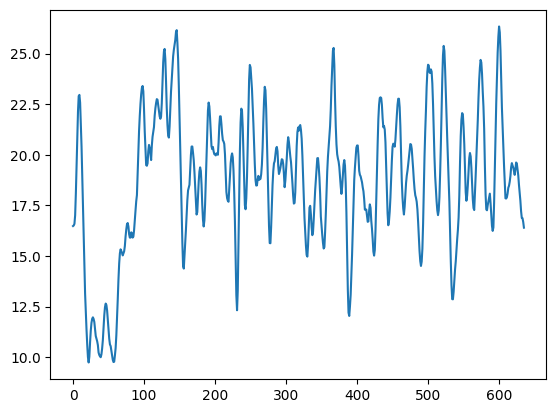

In [20]:
plt.plot(npd[['theta_O1']])

In [3]:
logf='/home/biorp/Documents/PlatformIO/Projects/SFSystem_withAV/session_lib/01.04.2024_05:35/current_training.log'

In [4]:
session_settings=json.loads('{"n_input_channels": 9, "channels_of_interest_inds": [0, 1, 2, 3, 4, 5, 6, 7, 16], "n_timepoints_per_sample": 500, "max_sfsystem_output": 1023, "reward_formula_string": "(fbin_2_7_ch4)/(fbin_8_25_ch4)", "fbins": [[2, 7], [8, 25]], "delay": 8, "use_raw_in_os_def": true, "use_freq_in_os_def": true, "use_fbins_in_os_def": true, "device_address": "ws://10.42.0.231:80/", "step_stim_length_millis": 60000, "episode_time_seconds": 180, "logfn": "current_training.log", "algorithm": "A2C", "policy": "MlpPolicy", "n_steps_per_timestep": 4}')

In [5]:
session_settings

{'n_input_channels': 9,
 'channels_of_interest_inds': [0, 1, 2, 3, 4, 5, 6, 7, 16],
 'n_timepoints_per_sample': 500,
 'max_sfsystem_output': 1023,
 'reward_formula_string': '(fbin_2_7_ch4)/(fbin_8_25_ch4)',
 'fbins': [[2, 7], [8, 25]],
 'delay': 8,
 'use_raw_in_os_def': True,
 'use_freq_in_os_def': True,
 'use_fbins_in_os_def': True,
 'device_address': 'ws://10.42.0.231:80/',
 'step_stim_length_millis': 60000,
 'episode_time_seconds': 180,
 'logfn': 'current_training.log',
 'algorithm': 'A2C',
 'policy': 'MlpPolicy',
 'n_steps_per_timestep': 4}

In [6]:
logf='/home/biorp/Documents/PlatformIO/Projects/SFSystem_withAV/session_lib/default_session/current_training.log'
session_settings=json.loads('{"n_input_channels": 9, "channels_of_interest_inds": [0, 1, 2, 3, 4, 5, 6, 7, 16], "n_timepoints_per_sample": 500, "max_sfsystem_output": 1023, "reward_formula_string": "(fbin_2_7_ch4)/(fbin_8_25_ch4)", "fbins": [[2, 7], [8, 25]], "delay": 8, "use_raw_in_os_def": true, "use_freq_in_os_def": true, "use_fbins_in_os_def": true, "device_address": "ws://10.42.0.231:80/", "step_stim_length_millis": 60000, "episode_time_seconds": 180, "logfn": "current_training.log", "algorithm": "A2C", "policy": "MlpPolicy", "n_steps_per_timestep": 4}')
channel_spec={0:'np_O1',1:'np_P3',2:'np_C3',3:'np_F3',4:'np_F4',5:'np_C4',6:'np_P4',7:'np_O2',
              8:'sf_ch1',9:'sf_ch2',10:'sf_ch3',11:'sf_ch4',12:'sf_ch5',13:'sf_ch6',14:'sf_ch7',15:'sf_ch8',16:'sf_enc'}

In [10]:
delay=session_settings['delay']
n_timepoints_per_sample=session_settings['n_timepoints_per_sample']
channels=[channel_spec[i] for i in session_settings['channels_of_interest_inds']]
reward_formula_string=session_settings['reward_formula_string']

In [8]:
startind=0
endind=10
chtoplot=['np_O1','sf_enc','reward']
plots=['raw_line','raw_heatmap','fft_line','fft_heatmap','bin_box','bin_heatmap', 'mxfreq_bins']
bins=[(0,1), (2,7), (8,25), (8,12), (12,30)]
startind=0
endind=10
all_chnames=list(channel_spec.values())


In [11]:
env = RLSystem.SFSystemCommunicator(offline_mode=True, input_channels=channels, n_timepoints_per_sample=n_timepoints_per_sample, delay=delay,
                                    reward_formula_string=reward_formula_string,
                                    fbins=bins) #input_channels=['sf_enc']) #, step_stim_length_millis=1000)

Default actions are set.


In [12]:
datas=[]
with open(logf, 'r') as f:
    while True:
        try:
            data = f.readline()
            data=json.loads(data)
            datas.append(data)
        except:
            break

In [33]:
datas[5]

{'leddelay': [100.0],
 'lv1r': [255.0],
 'lv1g': [226.9257155060768],
 'lv1b': [170.1605874300003],
 'lv2r': [157.03543305397034],
 'lv2g': [103.38142320513725],
 'lv2b': [255.0],
 'lv3r': [42.40928441286087],
 'lv3g': [248.813818693161],
 'lv3b': [239.34571355581284],
 'lv4r': [228.04214000701904],
 'lv4g': [174.5737725496292],
 'lv4b': [255.0],
 'lv5r': [244.69945758581161],
 'lv5g': [18.321963250637054],
 'lv5b': [222.50279009342194],
 'lv6r': [10.0],
 'lv6g': [255.0],
 'lv6b': [207.65706479549408],
 'lv7r': [239.6711152791977],
 'lv7g': [10.0],
 'lv7b': [255.0],
 'lv8r': [42.703544944524765],
 'lv8g': [154.1347971558571],
 'lv8b': [10.0],
 'wave_1_freq': [22656.327904224396],
 'wave_2_freq': [5153.618190705776],
 'panner_freq': [1.0],
 'phasor_1_freq': [50.0],
 'phasor_2_freq': [5.31260746717453],
 'phasor_1_min': [50.0],
 'phasor_2_min': [44.4070098400116],
 'phasor_1_dif': [48.03256595134735],
 'phasor_2_dif': [36.880669355392456],
 'panner_div': [2.597204804420471],
 'wave_1_typ

In [17]:
step_rewards={}
episode_total_rewards={}
act=False
acts={}
curepisode=0
curstep=0
rd=[]
#datapiece=0
curtimestep=None
for ind in range(len(datas)):
    i=datas[ind]
    if 'Episode' in i.keys() and 'Step' in i.keys():
        curepisode=i['Episode']
        curstep=i['Step']
        curtimestep=i['Timestamp']
    if 'Step reward' in i.keys():
        print(i)
        reward=i['Step reward']
        step_rewards[f't_{curtimestep}_ep_{curepisode}_step_{curstep}']=reward
        act=True
    if 'Action reward' in i.keys():
        #print(i)
        action=datas[ind+1]
        action_reward=i['Action reward']
        acts[float(action_reward)]=action
    if 'Episode total reward' in i.keys():
        print(i)
        #print(i)
        episode_total_rewards[f't_{curtimestep}_ep_{curepisode}']=i['Episode total reward']
        act=False
    # if 'fft' in i.keys():
    #     dt=i['fft']
    #     rs={'episode':curepisode, 'step':curstep}
    #     ffts.append(rs)
    if 'raw_data' in i.keys():
        dr=np.array(i['raw_data']).T
        rs={'episode':[curepisode for i in range(n_timepoints_per_sample)], 'step':[curstep for i in range(n_timepoints_per_sample)], 't':[curtimestep for i in range(n_timepoints_per_sample)]}
        for ci in range(len(dr)):
            rs[channel_spec[ci]]=dr[ci]
        rd.append(pd.DataFrame(rs))
      #  datapiece+=1
        
rdf=pd.concat(rd)
    

{'Timestamp': '04:04:2024_04:37:49', 'Episode': 0, 'Step': 0, 'Step reward': 0.0}
{'Timestamp': '04:04:2024_04:38:05', 'Episode': 0, 'Step': 1, 'Step reward': 0.0}
{'Timestamp': '04:04:2024_04:38:21', 'Episode': 0, 'Step': 2, 'Step reward': 0.0}
{'Timestamp': '04:04:2024_04:38:37', 'Episode': 0, 'Step': 3, 'Step reward': 0.0}
{'Timestamp': '04:04:2024_04:38:54', 'Episode': 0, 'Step': 4, 'Step reward': 0.0}
{'Timestamp': '04:04:2024_04:39:10', 'Episode': 0, 'Step': 5, 'Step reward': 0.0}


In [18]:
rdf

,episode,step,t,np_O1,np_P3,np_C3,np_F3,np_F4,np_C4,np_P4,np_O2,sf_ch1,sf_ch2,sf_ch3,sf_ch4,sf_ch5,sf_ch6,sf_ch7,sf_ch8,sf_enc
0,0,0,04:04:2024_04:37:49,-98.74,2833.53,-97.15,-94.44,219.41,10379.09,-97.24,13199.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,04:04:2024_04:37:49,422.10,359.02,422.12,419.48,2028.12,-4735.63,422.19,-4278.52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,04:04:2024_04:37:49,746.77,-1743.67,744.56,740.97,3350.01,-13309.48,745.24,-14676.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,04:04:2024_04:37:49,564.88,-9.56,563.97,564.52,2679.11,-2904.15,563.42,-3241.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,04:04:2024_04:37:49,269.55,3435.73,271.27,275.01,1168.77,12401.56,269.97,14784.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,5,04:04:2024_04:39:10,-708.85,573.98,-708.43,-705.10,-1954.10,2198.47,-707.93,7386.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0,5,04:04:2024_04:39:10,-699.91,5006.38,-698.43,-695.41,-1882.83,9969.57,-698.29,16069.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0,5,04:04:2024_04:39:10,-538.66,517.87,-538.27,-540.61,-1498.83,2602.91,-538.47,80.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0,5,04:04:2024_04:39:10,-254.34,-6153.50,-255.01,-259.22,-728.63,-9469.59,-254.83,-18241.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
def process_sfs_mainlog(logf):
    global channel_spec
    print('Reading the log file')
    datas=[]
    with open(logf, 'r') as f: #reading the log file
        while True:
            try:
                data = f.readline()
                data=json.loads(data)
                datas.append(data)
            except:
                break
    #print(datas)
    out_dict=datas[0]['out_dict']
    session_settings=datas[0]['session_settings']
    chofi=datas[0]['channels_of_interest']
    datas=datas[1:]
    delay=int(session_settings['delay'])
    n_timepoints_per_sample=int(session_settings['n_timepoints_per_sample'])
    channels=chofi
    reward_formula_string_orig=session_settings['reward_formula_string']
    step_rewards={}
    episode_total_rewards={}
    acts={}
    curepisode=0
    curstep=0
    rd=[]
    datapiece=0
    curtimestep=None
    crev=None
    for ind in range(len(datas)):
        i=datas[ind]
        if 'Episode' in i.keys() and 'Step' in i.keys():
            curepisode=i['Episode']
            curstep=i['Step']
            curtimestep=i['Timestamp']
        if 'Step reward' in i.keys():
            print(i)
            reward=i['Step reward']
            step_rewards[f't_{curtimestep}_ep_{curepisode}_step_{curstep}_dtp_{datapiece}']=reward
        if 'Action reward' in i.keys():
            #print(i)
            action=datas[ind+1]
            action_reward=i['Action reward']
            acts[float(action_reward)]=action
        if 'Episode total reward' in i.keys():
            print(i)
            #print(i)
            episode_total_rewards[f't_{curtimestep}_ep_{curepisode}_dtp_{datapiece}']=i['Episode total reward']
        # if 'fft' in i.keys():
        #     dt=i['fft']
        #     rs={'episode':curepisode, 'step':curstep}
        #     ffts.append(rs)
        if 'raw_data' in i.keys():
            dr=np.array(i['raw_data']).T
           # print(dr)
           
            rs={'episode':[curepisode for i in range(n_timepoints_per_sample)], 'step':[curstep for i in range(n_timepoints_per_sample)], 't':[curtimestep for i in range(n_timepoints_per_sample)], 'dtp':datapiece, 'wsi':list(range(n_timepoints_per_sample)), 'rev':[np.round(reward,2) for i in range(n_timepoints_per_sample)]}
            for ci in range(len(dr)):
              #  print(ci)
                rs[channel_spec[ci]]=dr[ci]
            rd.append(pd.DataFrame(rs))
        datapiece+=1
        
    rdf=pd.concat(rd)
   # print(rd)
    rdf['datapoint']='ep_'+rdf['episode'].astype(str)+'|st_'+rdf['step'].astype(str)+'|'+rdf['t']+'|'+rdf['dtp'].astype(str)+'|'+rdf['wsi'].astype(str)+'|'+rdf['rev'].astype(str)
    print('Logfile read done.')
    return {'session_settings':session_settings,
            'datas':datas,
            'delay':delay,
            'n_timepoints_per_sample':n_timepoints_per_sample,
            'fbins':session_settings['fbins'],
            'channels':channels,
            'reward_formula_string_orig':reward_formula_string_orig,
            'step_rewards':step_rewards, 
            'episode_total_rewards':episode_total_rewards, 
            'acts':acts, 
            'rdf':rdf}

In [129]:
logdata=process_sfs_mainlog(logf='/home/biorp/Documents/PlatformIO/Projects/SFSystem_withAV/session_lib/default_session/current_training.log')

Reading the log file
{'Timestamp': '04:04:2024_04:37:49', 'Episode': 0, 'Step': 0, 'Step reward': 0.0}
{'Timestamp': '04:04:2024_04:38:05', 'Episode': 0, 'Step': 1, 'Step reward': 0.0}
{'Timestamp': '04:04:2024_04:38:21', 'Episode': 0, 'Step': 2, 'Step reward': 0.0}
{'Timestamp': '04:04:2024_04:38:37', 'Episode': 0, 'Step': 3, 'Step reward': 0.0}
{'Timestamp': '04:04:2024_04:38:54', 'Episode': 0, 'Step': 4, 'Step reward': 0.0}
{'Timestamp': '04:04:2024_04:39:10', 'Episode': 0, 'Step': 5, 'Step reward': 0.0}
Logfile read done.


In [72]:
timesteps=logdata['rdf']['datapoint'].tolist()
print(len(timesteps))
lrsmax=len(timesteps)-1
dpts=logdata['rdf']['datapoint'].tolist()
marks={}
nts=len(timesteps)/(logdata['n_timepoints_per_sample'])
n_marks=10
if n_marks<nts:
    mark_every=int(np.floor(nts/n_marks))*logdata['n_timepoints_per_sample']
else:
    mark_every=logdata['n_timepoints_per_sample']
for i in range(0, len(timesteps), mark_every):
    marks[i]=dpts[i]
print('marks setup')

3000
marks setup


In [73]:
global log_env
log_env=RLSystem.SFSystemCommunicator(offline_mode=True, 
                                input_channels=logdata['channels'], 
                                n_timepoints_per_sample=logdata['n_timepoints_per_sample'], 
                                delay=logdata['delay'],
                                reward_formula_string=logdata['reward_formula_string_orig'],
                                fbins=logdata['fbins'])

Default actions are set.


In [132]:
rdf

,episode,step,t,dtp,wsi,rev,np_O1,np_P3,np_C3,np_F3,...,sf_ch1,sf_ch2,sf_ch3,sf_ch4,sf_ch5,sf_ch6,sf_ch7,sf_ch8,sf_enc,datapoint
0,0,0,04:04:2024_04:37:49,7,0,0.0,-98.74,2833.53,-97.15,-94.44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_0|04:04:2024_04:37:49|7|0|0.0
1,0,0,04:04:2024_04:37:49,7,1,0.0,422.10,359.02,422.12,419.48,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_0|04:04:2024_04:37:49|7|1|0.0
2,0,0,04:04:2024_04:37:49,7,2,0.0,746.77,-1743.67,744.56,740.97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_0|04:04:2024_04:37:49|7|2|0.0
3,0,0,04:04:2024_04:37:49,7,3,0.0,564.88,-9.56,563.97,564.52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_0|04:04:2024_04:37:49|7|3|0.0
4,0,0,04:04:2024_04:37:49,7,4,0.0,269.55,3435.73,271.27,275.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_0|04:04:2024_04:37:49|7|4|0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,5,04:04:2024_04:39:10,47,495,0.0,-708.85,573.98,-708.43,-705.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_5|04:04:2024_04:39:10|47|495|0.0
496,0,5,04:04:2024_04:39:10,47,496,0.0,-699.91,5006.38,-698.43,-695.41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_5|04:04:2024_04:39:10|47|496|0.0
497,0,5,04:04:2024_04:39:10,47,497,0.0,-538.66,517.87,-538.27,-540.61,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_5|04:04:2024_04:39:10|47|497|0.0
498,0,5,04:04:2024_04:39:10,47,498,0.0,-254.34,-6153.50,-255.01,-259.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_5|04:04:2024_04:39:10|47|498|0.0


In [74]:
sdata=logdata

In [76]:
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = 'simple_white'

In [84]:
episode_total_rewards

{}

In [89]:
sdata['rdf']=rdf.to_json(orient='records')

In [90]:
step_rewards=sdata['step_rewards']
episode_total_rewards=sdata['episode_total_rewards']
acts=sdata['acts']
rdf=pd.read_json(sdata['rdf'], orient='records')
print(step_rewards)
print(episode_total_rewards)
orig_reward_fig=go.Figure(data=go.Scatter(x=list(step_rewards.keys()), y=list(step_rewards.values()), mode='lines'))
orig_reward_fig.update_layout(title=f'Step reward data')
orig_episode_reward_fig=go.Figure(data=go.Scatter(x=list(episode_total_rewards.keys()), y=list(episode_total_rewards.values()), mode='lines'))
orig_episode_reward_fig.update_layout(title=f'Total episode reward data')

global log_env

{'t_04:04:2024_04:37:49_ep_0_step_0_dtp_0': 0.0, 't_04:04:2024_04:38:05_ep_0_step_1_dtp_8': 0.0, 't_04:04:2024_04:38:21_ep_0_step_2_dtp_16': 0.0, 't_04:04:2024_04:38:37_ep_0_step_3_dtp_24': 0.0, 't_04:04:2024_04:38:54_ep_0_step_4_dtp_32': 0.0, 't_04:04:2024_04:39:10_ep_0_step_5_dtp_40': 0.0}
{}


In [100]:
startind

0

In [109]:
endind=500

In [110]:
crd=rdf.iloc[startind:endind]
crd=crd.to_numpy()[:,3:-1]
cffts=env.get_fft_allchannels(crd)
fbins_data=env.get_bin_values_allchannels(cffts)


In [83]:
analysis_step=5

In [117]:
crd.shape

(5500, 17)

In [120]:
nbins=int(np.floor(crd.shape[0]/analysis_step))

In [121]:
nbins

1100

In [123]:
databins=np.array_split(crd,nbins)

In [125]:
len(databins)

1100

In [126]:
databins[0].shape

(5, 17)

In [127]:
bin_vals_ns=[]
for nsraw in databins:
    nsfft=env.get_fft_allchannels(nsraw)
    nsfbins=env.get_fft_allchannels(nsfft)
    bin_vals_ns.append(nsfbins)
bin_vals_ns=np.array(bin_vals_ns)

In [128]:
bin_vals_ns.shape

(1100, 5, 17)

In [133]:
bin_vals_ns[:,:,1].shape

(1100, 5)

In [135]:
bin_vals_ns[:,:,16].shape

(1100, 5)

In [138]:
figs_bin_values = []
for i in range(bin_vals_ns.shape[2]):
    chbins=bin_vals_ns[:,:,i]
    fig = go.Figure()
    for i in range(chbins.shape[1]):
        fig.add_trace(go.Scatter(x=list(range(chbins.shape[0])), y=chbins[:, i], mode='lines', name=f'Bin {env.fbin_axis_labels[i]}'))
    fig.update_layout(title=f'Bin Values for Channel {all_chnames[i]} Over Time')
figs_bin_values.append(fig)

In [139]:
figs_bin_values[0].show()

In [141]:
bin_vals_ns.shape

(1100, 5, 17)

In [149]:
figs_bin_heatmaps = []
for i in range(bin_vals_ns.shape[1]):
    chbins=bin_vals_ns[:,i,:]
    fig=go.Figure(data=go.Heatmap(z=chbins.T, x=list(range(chbins.shape[0])), y=all_chnames))
    fig.update_layout(title=f'Heatmap of Bin {env.fbin_axis_labels[i]} Results')
    figs_bin_heatmaps.append(fig)

In [150]:
bin_vals_ns[:,0,:].shape

(1100, 17)

In [151]:
figs_bin_heatmaps[0].show()

In [198]:
new_rewards=[]
nsteps=int(crd.shape[0]/env.n_timepoints_per_sample)
origdatasplit=np.array_split(crd,nsteps)
for i in origdatasplit:
    nobs={}
    nobs['raw_data']=i[:,env.channels_of_interest_inds]
    nobs['fft']=env.get_fft_allchannels(nobs['raw_data'])
    nobs['fbins']=env.get_bin_values_allchannels(nobs['fft'])
    rev=env.get_reward(nobs, toreturn=True)
    new_rewards.append(rev)

new_rewards=np.array(new_rewards).reshape(-1)

In [199]:
new_rewards

array([1.9996086 , 1.67464812, 1.39512646, 1.05696868, 1.44513535,
       1.34003575, 1.51420183, 1.64192587, 1.30643263, 1.6142084 ,
       1.14597796])

In [141]:
env.all_input_channels

['np_O1',
 'np_P3',
 'np_C3',
 'np_F3',
 'np_F4',
 'np_C4',
 'np_P4',
 'np_O2',
 'sf_ch1',
 'sf_ch2',
 'sf_ch3',
 'sf_ch4',
 'sf_ch5',
 'sf_ch6',
 'sf_ch7',
 'sf_ch8',
 'sf_enc']

In [ ]:
rdf['datapoint']='ep_'+rdf['episode'].astype(str)+'|st_'+rdf['step'].astype(str)+'|'+rdf['t']+'|'+rdf['dtp'].astype(str)

In [140]:
rdf

,episode,step,t,dtp,wsi,rev,np_O1,np_P3,np_C3,np_F3,...,sf_ch1,sf_ch2,sf_ch3,sf_ch4,sf_ch5,sf_ch6,sf_ch7,sf_ch8,sf_enc,datapoint
0,0,0,04:04:2024_04:37:49,7,0,0.0,-98.74,2833.53,-97.15,-94.44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_0|04:04:2024_04:37:49|7|0|0.0
1,0,0,04:04:2024_04:37:49,7,1,0.0,422.10,359.02,422.12,419.48,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_0|04:04:2024_04:37:49|7|1|0.0
2,0,0,04:04:2024_04:37:49,7,2,0.0,746.77,-1743.67,744.56,740.97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_0|04:04:2024_04:37:49|7|2|0.0
3,0,0,04:04:2024_04:37:49,7,3,0.0,564.88,-9.56,563.97,564.52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_0|04:04:2024_04:37:49|7|3|0.0
4,0,0,04:04:2024_04:37:49,7,4,0.0,269.55,3435.73,271.27,275.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_0|04:04:2024_04:37:49|7|4|0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,5,04:04:2024_04:39:10,47,495,0.0,-708.85,573.98,-708.43,-705.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_5|04:04:2024_04:39:10|47|495|0.0
496,0,5,04:04:2024_04:39:10,47,496,0.0,-699.91,5006.38,-698.43,-695.41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_5|04:04:2024_04:39:10|47|496|0.0
497,0,5,04:04:2024_04:39:10,47,497,0.0,-538.66,517.87,-538.27,-540.61,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_5|04:04:2024_04:39:10|47|497|0.0
498,0,5,04:04:2024_04:39:10,47,498,0.0,-254.34,-6153.50,-255.01,-259.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ep_0|st_5|04:04:2024_04:39:10|47|498|0.0


In [176]:
origdatasplit[0].shape

(500, 17)

In [165]:
nsteps

11

In [167]:
origdatasplit[0].shape

(500, 17)

In [164]:
crd

array([[ 1.280000e+00,  9.440000e+00, -2.815500e+02, ...,  2.432494e+06,
         7.185160e+06,  0.000000e+00],
       [ 9.257000e+01,  6.039000e+01, -2.382000e+02, ...,  2.432494e+06,
         7.185160e+06,  0.000000e+00],
       [ 2.212000e+01, -1.894000e+01, -2.909500e+02, ...,  2.432494e+06,
         7.185160e+06,  0.000000e+00],
       ...,
       [-1.090000e+00,  6.330000e+00,  1.570000e+00, ...,  8.388607e+06,
         8.388607e+06,  0.000000e+00],
       [ 4.880000e+00,  4.970000e+00,  8.000000e-02, ...,  8.388607e+06,
         8.388607e+06,  0.000000e+00],
       [ 1.234000e+01,  6.310000e+00,  1.120000e+00, ...,  8.388607e+06,
         8.388607e+06,  0.000000e+00]])

In [ ]:
env.get_reward()

In [38]:
crd.shape

(5500, 17)

In [39]:
cffts.shape

(17, 251)

In [40]:
env.f_plot

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 ,
       15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75,
       18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  ,
       20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75, 22.  , 22.25,
       22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75, 24.  , 24.25, 24.5 ,
       24.75, 25.  , 25.25, 25.5 , 25.75, 26.  , 26.25, 26.5 , 26.75,
       27.  , 27.25, 27.5 , 27.75, 28.  , 28.25, 28.5 , 28.75, 29.  ,
       29.25, 29.5 , 29.75, 30.  , 30.25, 30.5 , 30.75, 31.  , 31.25,
       31.5 , 31.75,

In [41]:
len(env.f_plot)

251

In [42]:
fbins_data.shape

(17, 5)

In [43]:
env.fbin_axis_labels

['0-1 Hz', '2-7 Hz', '8-25 Hz', '8-12 Hz', '12-30 Hz']

In [58]:
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = 'simple_white'
raw_signal=crd
# Assuming timepoints is an array of the same length as the first dimension of raw_signal
timepoints = np.arange(raw_signal.shape[0])

figs_raw_signal = []
for i in range(raw_signal.shape[1]):
    fig = go.Figure(data=go.Scatter(x=timepoints, y=raw_signal[:, i], mode='lines'))
    fig.update_layout(title=f'Raw Signal for Channel {all_chnames[i]}')
    figs_raw_signal.append(fig)

In [114]:
crd.shape

(500, 17)

In [115]:
env.all_input_channels

['np_O1',
 'np_P3',
 'np_C3',
 'np_F3',
 'np_F4',
 'np_C4',
 'np_P4',
 'np_O2',
 'sf_ch1',
 'sf_ch2',
 'sf_ch3',
 'sf_ch4',
 'sf_ch5',
 'sf_ch6',
 'sf_ch7',
 'sf_ch8',
 'sf_enc']

In [120]:
raw_signal

array([[-98.74, 2833.53, -97.15, ..., 0, 0, 0],
       [422.1, 359.02, 422.12, ..., 0, 0, 0],
       [746.77, -1743.67, 744.56, ..., 0, 0, 0],
       ...,
       [-351.15, -22.05, -350.58, ..., 0, 0, 0],
       [-407.75, 2198.76, -406.48, ..., 0, 0, 0],
       [72.76, 1215.1, 72.61, ..., 0, 0, 0]], dtype=object)

In [135]:
crd

array([[-98.74, 2833.53, -97.15, ..., 0, 0, 0],
       [422.1, 359.02, 422.12, ..., 0, 0, 0],
       [746.77, -1743.67, 744.56, ..., 0, 0, 0],
       ...,
       [-351.15, -22.05, -350.58, ..., 0, 0, 0],
       [-407.75, 2198.76, -406.48, ..., 0, 0, 0],
       [72.76, 1215.1, 72.61, ..., 0, 0, 0]], dtype=object)

In [133]:
raw_signal=crd
figs_raw_signal = []
timepoints=rdf.datapoint.tolist()
for i in range(raw_signal.shape[1]):
    fig = go.Figure(data=go.Scatter(x=timepoints, y=raw_signal[:, i], mode='lines'))
    fig.update_layout(title=f'Raw Signal for Channel {env.all_input_channels[i]}')
    figs_raw_signal.append(fig)

In [134]:
figs_raw_signal[1]


In [136]:
cffts.shape

(17, 251)

In [138]:
cffts[:,2:10]

array([[  38.83622719,   42.45513126,   50.89931794,   72.17160522,
          80.88739387,   58.37507605,  109.52938299,  343.96011862],
       [ 104.41692424,  115.41390105,  143.05489995,  197.70266685,
         196.60619427,  110.58138211,  452.87647006, 1153.54673099],
       [  38.82336363,   42.42572858,   50.94377887,   72.14796295,
          80.7817114 ,   58.26344478,  109.55636687,  343.90759066],
       [  38.82021583,   42.46970421,   50.97735378,   72.2392247 ,
          80.84623997,   58.4829907 ,  109.58450548,  344.29823435],
       [ 138.32271816,  156.45241622,  175.65899673,  257.60501871,
         291.56977892,  296.48895651,  437.18908826, 1190.18533369],
       [  42.42637275,   49.46818998,   65.6392867 ,  107.31089538,
         118.89314481,   40.48810248,  157.19432637,  644.65989124],
       [  38.76496887,   42.38818122,   50.89668169,   72.13143021,
          80.7823088 ,   58.29179372,  109.44550797,  343.82213538],
       [  49.47157521,   59.3394066 ,   7

In [139]:
env.f_plot.index(0.0)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [60]:
figs_fft = []
for i in range(cffts.shape[0]):
    fig = go.Figure(data=go.Scatter(x=env.f_plot, y=cffts[i], mode='lines'))
    fig.update_layout(title=f'FFT for Channel {all_chnames[i]}')
    figs_fft.append(fig)

In [70]:
fig_heatmap_fft = go.Figure(data=go.Heatmap(z=cffts, x=timepoints, y=all_chnames))
fig_heatmap_fft.update_layout(title='Heatmap of FFT Results')

In [76]:
fig_heatmap_raw = go.Figure(data=go.Heatmap(z=raw_signal.T, y=all_chnames, x=np.arange(raw_signal.shape[1])))
fig_heatmap_raw.update_layout(title='Heatmap of Raw Signal for All Channels')

In [78]:
bin_figs=[]
for chidx in range(len(all_chnames)):
    chbins=fbins_data[chidx]
    fig = go.Figure(data=go.Bar(x=env.fbin_axis_labels, y=chbins, name=f'Channel {all_chnames[chidx]} frequency bins'))
    fig.update_layout(title=f'Signal Bins for {all_chnames[i]}')
    bin_figs.append(fig)
   

In [79]:
bin_figs[0].show()

In [103]:
len(step_rewards.keys())

41

In [104]:
len(acts.keys())

41

In [112]:
htextdata=list(map(str,list(acts.values())))
hover_text = [
    f'<div style="width: 200px; height: 100px; overflow-y: scroll; border: 1px solid black; padding: 5px;">', hover_data=htextdata
for i in range(len(htextdata))] 

In [116]:
orig_reward_fig=go.Figure(data=go.Scatter(x=list(step_rewards.keys()), y=list(acts.keys()), mode='lines'))
orig_reward_fig.update_layout(title=f'Step reward data')

In [108]:
orig_episode_reward_fig=go.Figure(data=go.Scatter(x=list(episode_total_rewards.keys()), y=list(episode_total_rewards.values()), mode='lines'))
orig_episode_reward_fig.update_layout(title=f'Total episode reward data')

### Getting best action

In [6]:
np.max(step_rewards[2:-1])

1.6419258667470478

In [12]:
print(json.dumps(acts[1.6419258667470478]))

{"leddelay": [100.0], "lv1r": [10.0], "lv1g": [82.90587425231934], "lv1b": [145.4329040646553], "lv2r": [10.0], "lv2g": [92.47760325670242], "lv2b": [255.0], "lv3r": [141.7644789814949], "lv3g": [186.74919724464417], "lv3b": [10.0], "lv4r": [225.07276713848114], "lv4g": [255.0], "lv4b": [144.88865971565247], "lv5r": [10.0], "lv5g": [17.08536222577095], "lv5b": [219.57975298166275], "lv6r": [10.0], "lv6g": [255.0], "lv6b": [163.5152980685234], "lv7r": [114.79197204113007], "lv7g": [93.66294726729393], "lv7b": [152.9974463582039], "lv8r": [119.71295207738876], "lv8g": [142.57026553153992], "lv8b": [255.0], "wave_1_freq": [25166.88841354847], "wave_2_freq": [19244.299842357635], "panner_freq": [45.50972491502762], "phasor_1_freq": [1.0], "phasor_2_freq": [50.0], "phasor_1_min": [32.48806589841843], "phasor_2_min": [50.0], "phasor_1_dif": [1.0], "phasor_2_dif": [11.235592037439346], "panner_div": [4.219188213348389], "wave_1_type": [1.6291682124137878], "wave_2_type": [2.4191304445266724],